In [1]:
# Imports
# import restricted.data_query as dq

import psycopg2 as pg
import pickle
import pandas.io.sql as psql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scikitplot as skplt

from IPython.core.display import HTML
from IPython.core.display import Image

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm



In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display( HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # sns.set()
jupyter_settings()

def numerical_metrics(numerical_attributes):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25))).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75))).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns = ['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes

def correlation_matrix(data, cols_drop, method):
   
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64', 'int32'])
    num_attributes = num_attributes.drop(columns = cols_drop )
    correlation = num_attributes.corr(method = method)

    # plot
    matrix = sns.heatmap(correlation, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return matrix

Populating the interactive namespace from numpy and matplotlib


## Data loading

In [3]:
# host = dq.dq_host
# username = dq.dq_username
# port = dq.dq_port
# database = dq.dq_database
# pwd = dq.dq_pwd

# conn = pg.connect( user = username,
#                    password = pwd,
#                    host = host,
#                    port = port,
#                    database = database)

# query_tables_users = """
#                 SELECT *
#                 FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
#                                     LEFT JOIN pa004.insurance i ON (u.id = i.id)                                 
#                 """

In [4]:
# df.to_pickle('df.pkl')
df = pd.read_pickle('df.pkl')

# Data Cleaning

In [5]:
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


## Checking NAs and dtypes

In [6]:
df.gender = df.gender.astype(str)


In [7]:
df.region_code.unique()
df.region_code = df.region_code.astype('int')
df.policy_sales_channel.unique()
df.policy_sales_channel = df.policy_sales_channel.astype('int')
# df.vehicle_age.unique() # < >  <>
# df.vehicle_damage.unique() # yes / no
# df.previously_insured.unique()  # bool 0/1
# df.vintage.unique()
# df.response.unique()  # 0/1

In [8]:
df.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'id',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [9]:
# drop repeated columns
df.columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'ida',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'ida',
       'previously_insured', 'annual_premium', 'vintage', 'response']
df = df.drop(df.columns[[5,9]], axis = 1)

In [10]:
df.info()  # Non-null number all the same, non missing data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  int32  
 4   policy_sales_channel  381109 non-null  int32  
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(3)
memory usage: 32.0+ MB


## Checking target variable balance

In [11]:
df['response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## Dimension

In [12]:
print(f"Total Columns: {df.shape[1]}")
print(f"Total Rows: {df.shape[0]}")

Total Columns: 12
Total Rows: 381109


# EDA

## Descriptive Statistics

### Numerical Attributes

In [13]:
numerical_attributes = df[['age', 'annual_premium', 'vintage']]
numerical_result = numerical_metrics(numerical_attributes)
numerical_result


,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,25.0,49.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,24405.0,39400.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,82.0,227.0,83.671194,0.003030,-1.200688


### Categorical Attributes

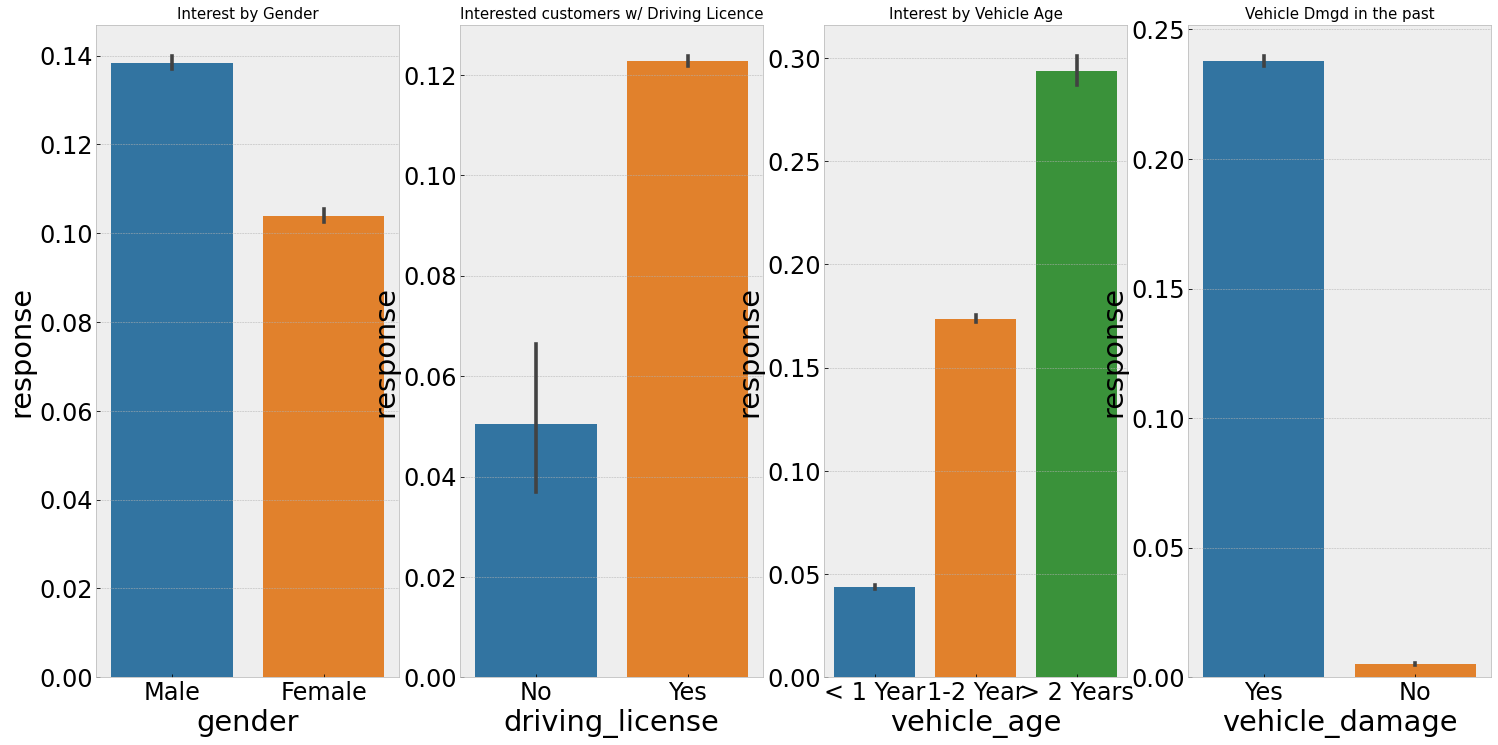

In [14]:
cat_attributes = df[['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

plt.subplot(1, 4, 1)
sns.barplot(x = 'gender', y = 'response', data = cat_attributes, palette = 'tab10')
plt.title('Interest by Gender', fontsize = 15);

plt.subplot(1, 4, 2)
sns.barplot(x = 'driving_license', y = 'response', data = cat_attributes, palette = 'tab10')
plt.xticks([0,1],['No','Yes']);
plt.title('Interested customers w/ Driving Licence', fontsize = 15);

plt.subplot(1, 4, 3)
sns.barplot(x = 'vehicle_age', y = 'response', data = cat_attributes, palette = 'tab10')
plt.title('Interest by Vehicle Age', fontsize = 15);

plt.subplot(1, 4, 4)
sns.barplot(x = 'vehicle_damage', y = 'response', data = cat_attributes, palette = 'tab10')
plt.title('Vehicle Dmgd in the past', fontsize = 15);

- Males are more interested
- People with driving license more likely to buy the new product
- The older the vehicle the more the interest.
- Damage in the vehicle in the past makes people want to do the car insurance.

## Univariate Analysis

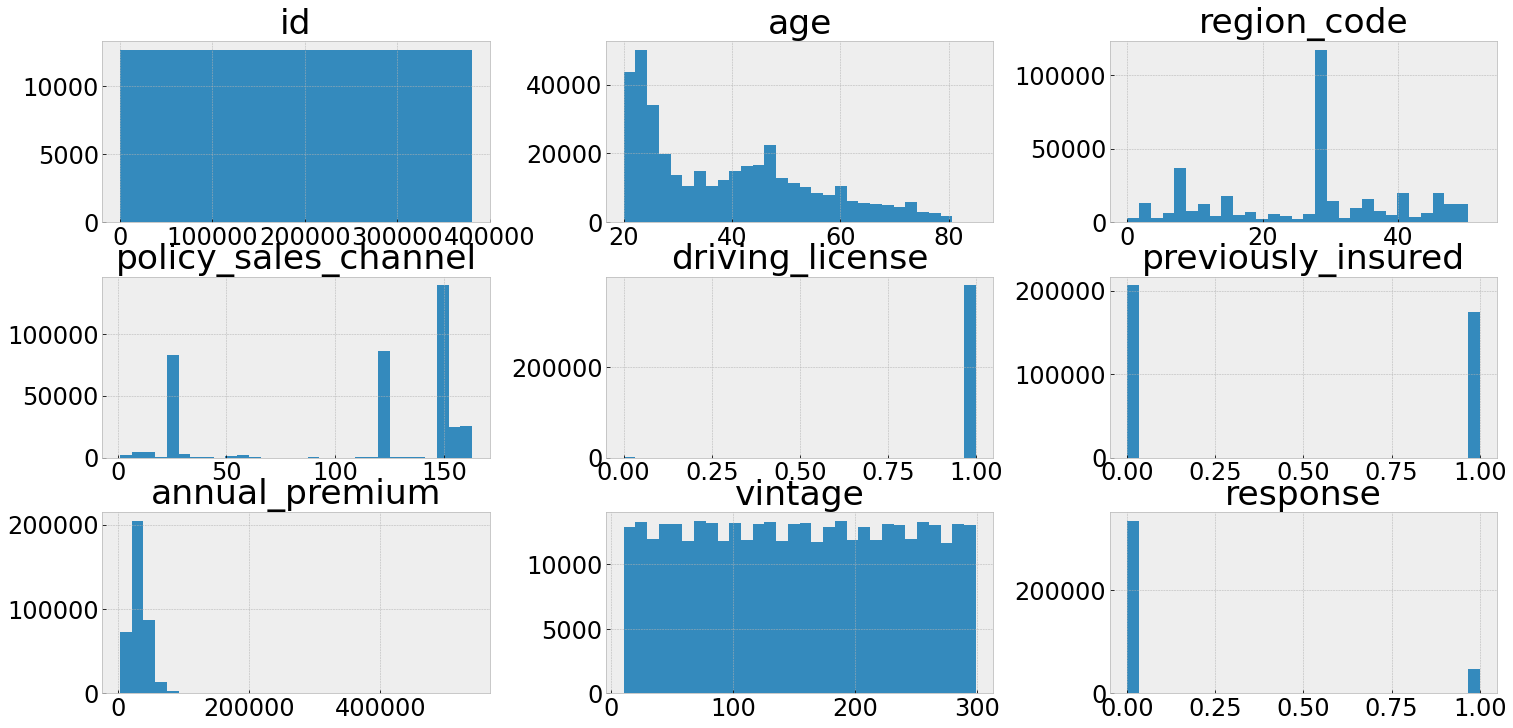

In [15]:
df.hist(bins = 30);


- age, right Skewed  
- region_code seems left skewed  
- annual_premium, right skeed  
- policy_sales_channel, left skewed



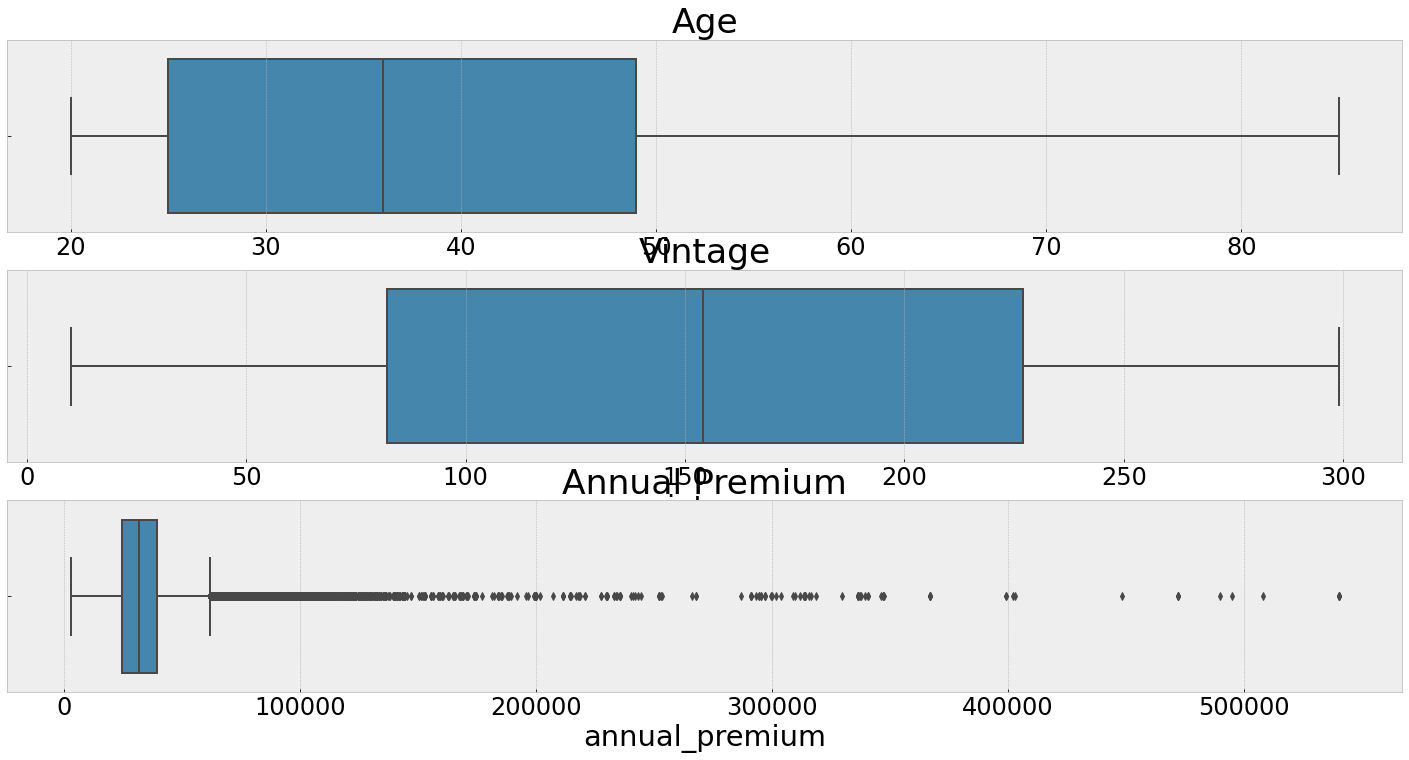

In [16]:
plt.subplot(3,1,1)
sns.boxplot(x = 'age', data = df).set(title = "Age")
plt.subplot(3,1,2)
sns.boxplot(x = 'vintage', data = df).set(title = "Vintage")
plt.subplot(3,1,3)
sns.boxplot(x = 'annual_premium', data = df).set(title = "Annual Premium");

Some premiums are very high

In [17]:
df.annual_premium.quantile(.75)

39400.0

## Multivariate analysis

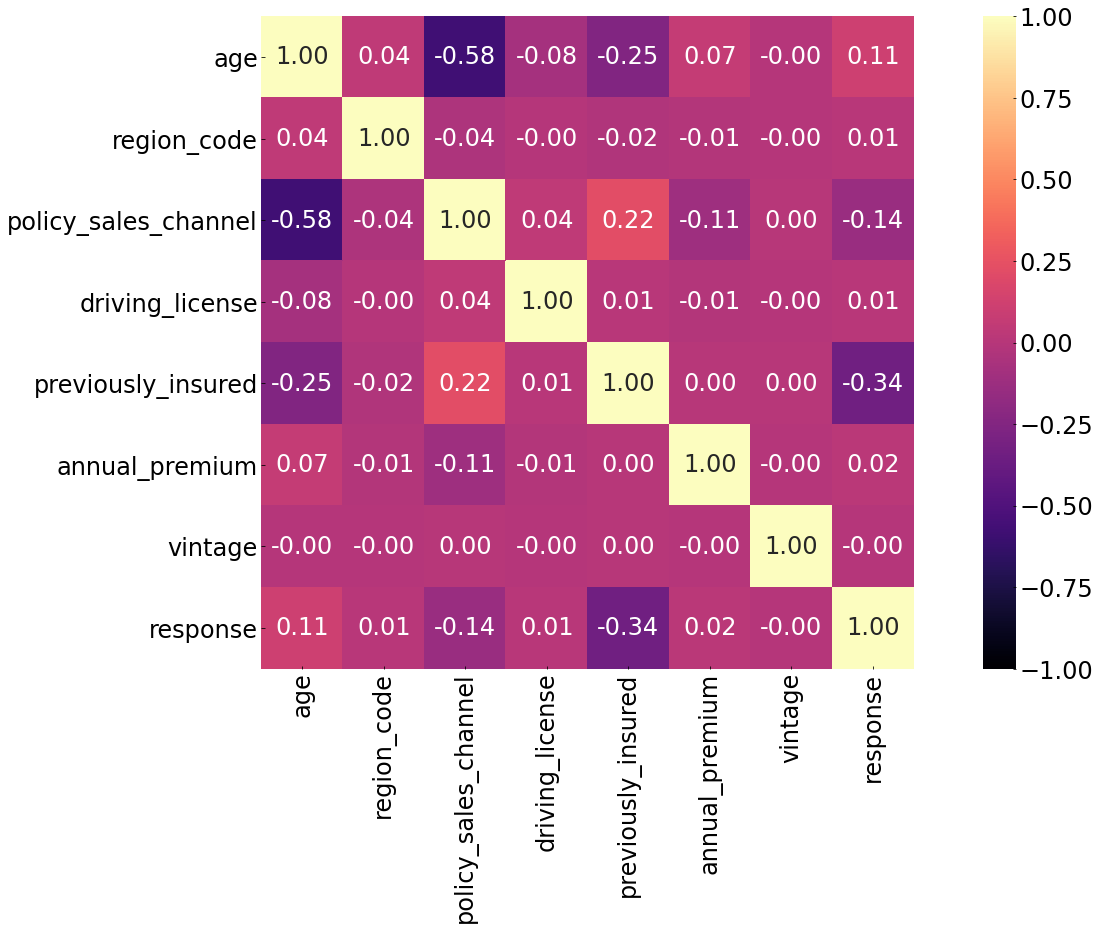

In [72]:
correlation_matrix(df, ['id'],'pearson');

## Comparing Dataset according to survey

### Total Proportion of positive responses

In [18]:
print('Total Observations: ' + str(df.shape[0]))
tot_resp = df.shape[0]
pos_resp = df[df['response'] == 1].shape[0]
neg_resp = df[df['response'] == 0].shape[0]

print(f'Total Positive Responses: {str(pos_resp )}     {pos_resp / tot_resp*100:.2f}%')
print(f'Total Negative Responses: {str(neg_resp )}    {neg_resp / tot_resp * 100:.2f}%')

Total Observations: 381109
Total Positive Responses: 46710     12.26%
Total Negative Responses: 334399    87.74%


### Gender

[Text(0.5, 1.0, 'Gender Population Composition')]

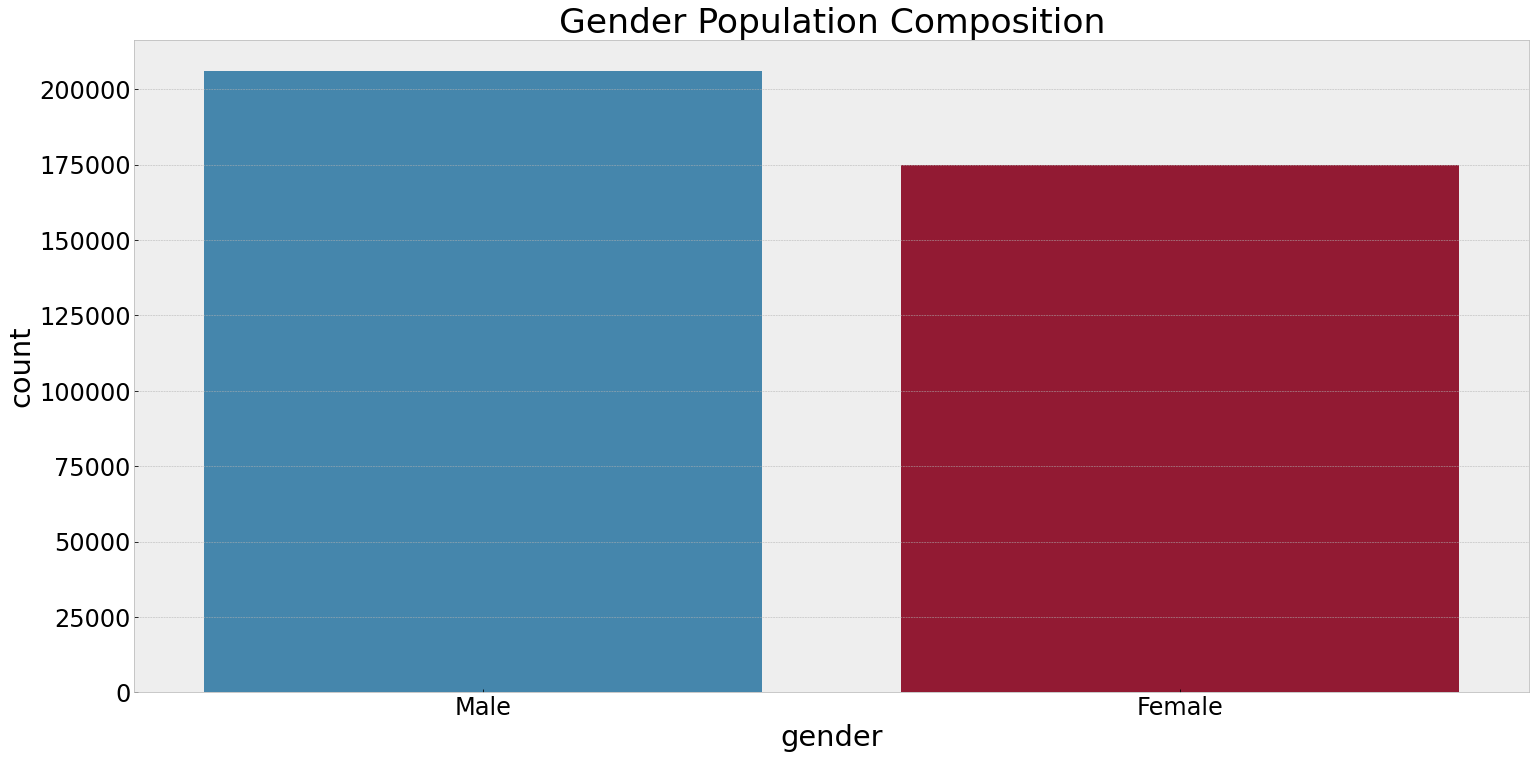

In [19]:
sns.countplot(data = df, x = 'gender').set(title = "Gender Population Composition")

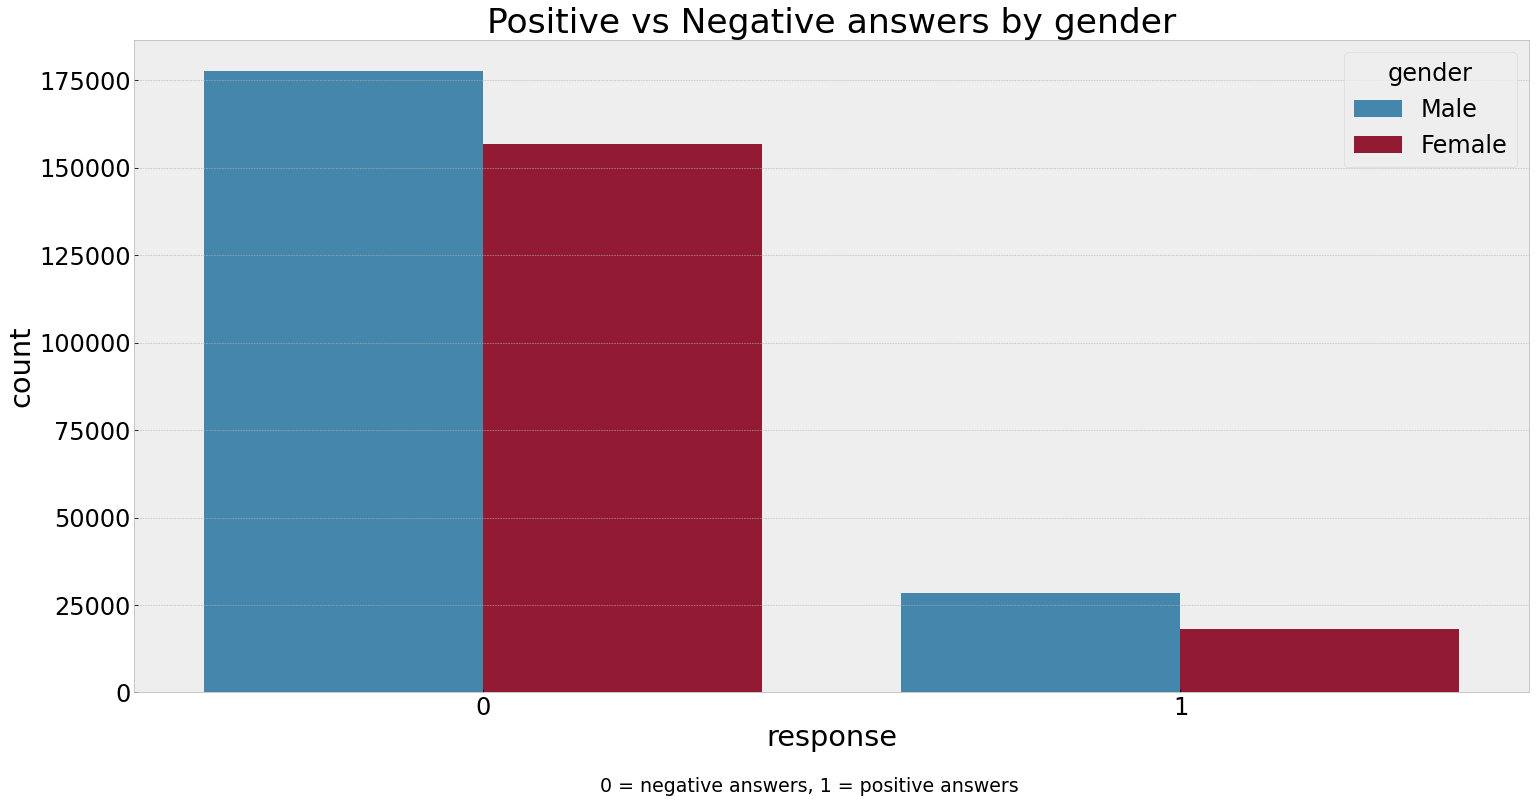

In [20]:
sns.countplot(data = df, x = 'response', hue = 'gender').set(title = 'Positive vs Negative answers by gender');
txt = '0 = negative answers, 1 = positive answers'
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=19);

- Men tends to give more positive answers, however it represents a larger portion of the dataset.

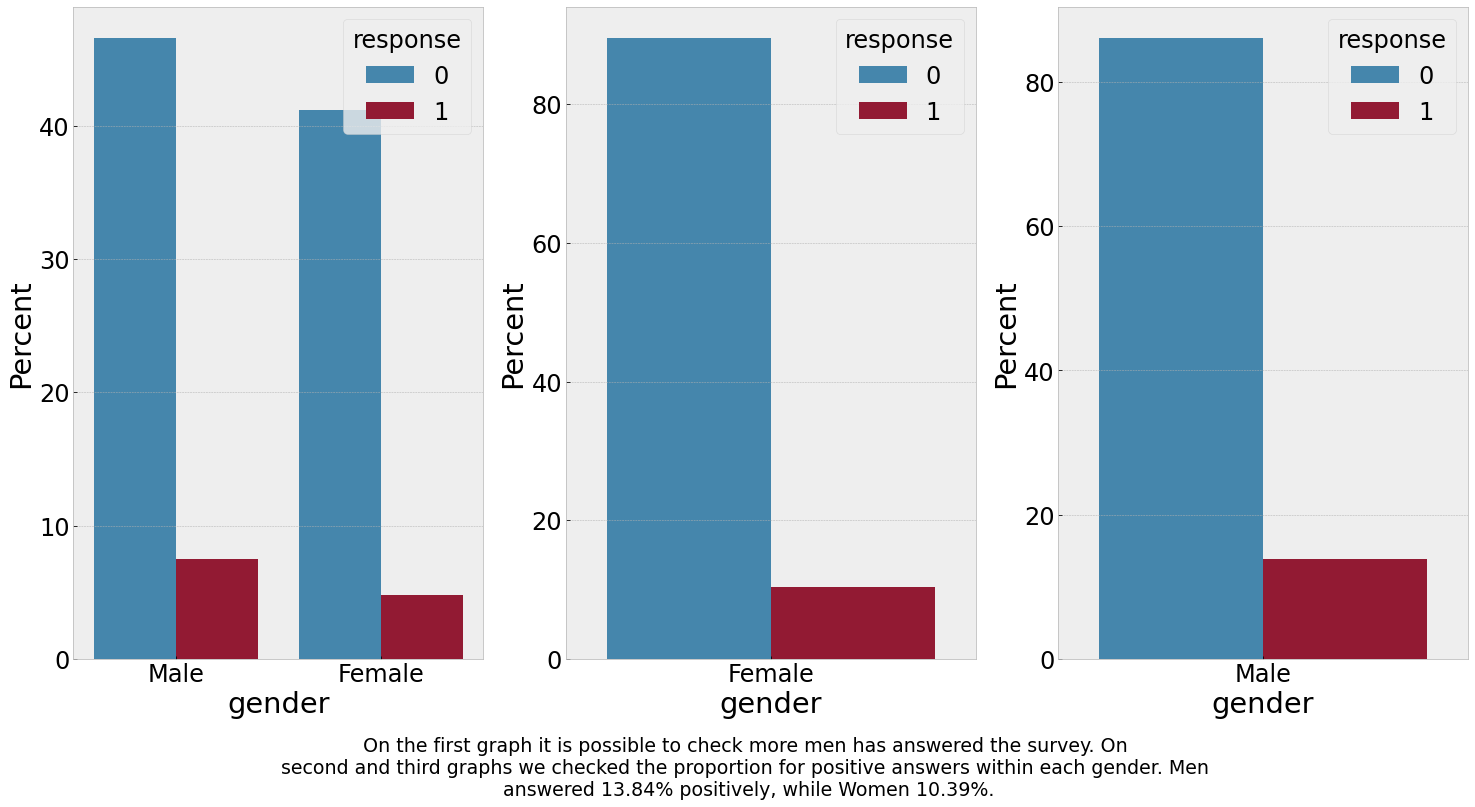

In [21]:
plt.subplot(1,3,1)
ax1 = sns.barplot(x="gender", y="response", hue = 'response', data=df, estimator=lambda x: len(x) / len(df) * 100)
ax1.set(ylabel="Percent")

plt.subplot(1,3,2)
df_aux_female = df[df['gender'] == 'Female']
ax2 = sns.barplot(x="gender", y = 'response', hue = 'response', data=df_aux_female, estimator=lambda x: len(x) / len(df_aux_female) * 100)
ax2.set(ylabel="Percent")
fem_data = len(df_aux_female[df_aux_female['response'] == 1]) / len(df_aux_female) * 100

plt.subplot(1,3,3)
df_aux_male = df[df['gender'] == 'Male']
ax3 = sns.barplot(x="gender", y='response', hue='response', data=df_aux_male, estimator=lambda x: len(x) / len(df_aux_male) * 100)
ax3.set(ylabel="Percent")
male_data = len(df_aux_male[df_aux_male['response'] == 1]) / len(df_aux_male) * 100
txt=f"On the first graph it is possible to check more men has answered the survey. On \nsecond and third graphs we checked the proportion for positive answers within each gender. Men \nanswered {male_data:.2f}% positively, while Women {fem_data:.2f}%."
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=19);



### Age as a factor for Responses

   binned_age   total  negative  positive   pos_tot
0    (20, 25]  108273    104397      3876  0.035798
1    (25, 30]   46956     43820      3136  0.066786
2    (30, 35]   25351     20289      5062  0.199677
3    (35, 40]   29812     23277      6535  0.219207
4    (40, 45]   40720     32063      8657  0.212598
5    (45, 50]   35221     27853      7368  0.209193
6    (50, 55]   26328     21573      4755  0.180606
7    (55, 60]   18977     16016      2961  0.156031
8    (60, 65]   15170     13316      1854  0.122215
9    (65, 70]   12668     11479      1189  0.093859
10   (70, 75]    9448      8699       749  0.079276
11   (75, 80]    5824      5433       391  0.067136
12   (80, 85]     129       123         6  0.046512


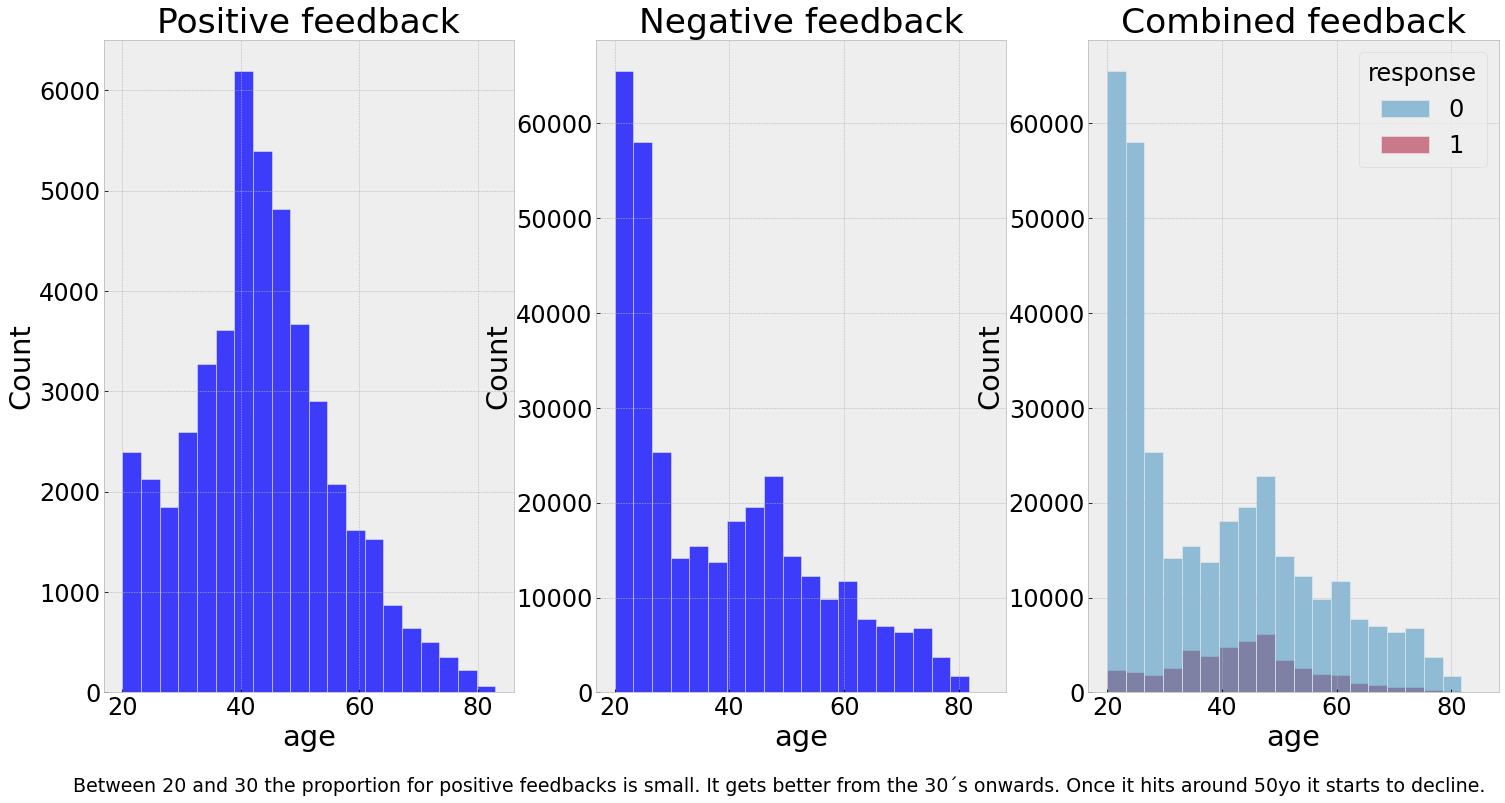

In [22]:
df_positive_feedback = df[df['response'] == 1];

df_negative_feedback = df[df['response'] == 0];


bins = list(range(20,90,5))
df['binned_age'] = pd.cut(df['age'], bins=bins)
age_proportional_aux1 = df[['binned_age','response']].groupby('binned_age').count().reset_index()  # total
age_proportional_aux2 = df[df['response'] == 0][['binned_age','response']].groupby('binned_age').count().reset_index()  # neg
age_proportional_aux3 = df[df['response'] == 1][['binned_age','response']].groupby('binned_age').count().reset_index()  # pos
age_proportional = pd.concat([age_proportional_aux1,age_proportional_aux2,age_proportional_aux3], axis = 1)
age_proportional.columns = ['binned_age','total','b1','negative','b2','positive']
age_proportional = age_proportional.drop(age_proportional.columns[[2,4]], axis = 1)
age_proportional['pos_tot'] = age_proportional.positive / age_proportional.total
print(age_proportional)




fig, axes = plt.subplots(1,3)
sns.histplot(x = 'age', data = df_positive_feedback, ax = axes[0], bins = 20).set(title='Positive feedback')
sns.histplot(x = 'age', data = df_negative_feedback, ax = axes[1], bins = 20).set(title='Negative feedback')
sns.histplot(x = 'age', data = df, hue = 'response', ax = axes[2], bins = 20).set(title='Combined feedback')


txt=f"Between 20 and 30 the proportion for positive feedbacks is small. It gets better from the 30´s onwards. Once it hits around 50yo it starts to decline."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=19);


- Age can be significant in terms of obtaining positive feedback towards car insurance.

### Region Code

In [23]:
region = df[['response','region_code','id']].groupby(['region_code','response']).count().reset_index()

In [24]:
region['pos_response'] = region.apply(lambda x: x['id'] if x['response'] == 1 else 0, axis = 1)

In [25]:
region['neg_response'] = region.apply(lambda x: x['id'] if x['response'] == 0 else 0, axis = 1)

In [26]:
type(region)

region = region[['region_code','pos_response','neg_response']].groupby('region_code').sum().reset_index()

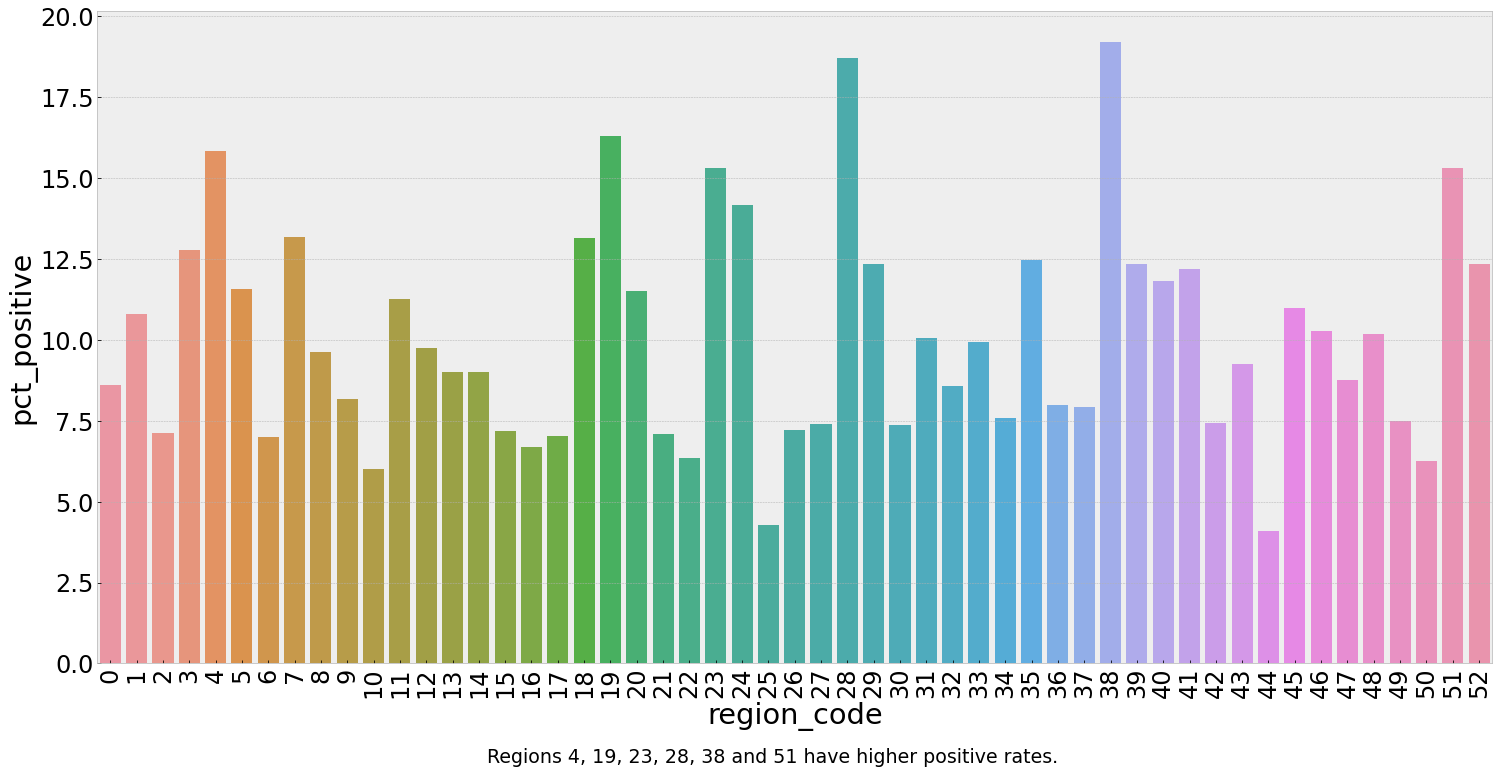

In [27]:
region['tot_answers'] = region['pos_response'] + region['neg_response']

region['pct_positive'] = region['pos_response'] / region['tot_answers'] * 100
region.head(24)
sns.barplot(x = 'region_code', y = 'pct_positive', data = region)
plt.xticks(rotation = 90);
txt=f"Regions 4, 19, 23, 28, 38 and 51 have higher positive rates."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=19);

- Could be object of analysis the comparison the possible reasons some regions have higher positive feedback.

### Policy sales Channel

In [28]:
# sns.barplot(y = 'policy_sales_channel', hue = 'response', data = df)

sales_channel = df[['policy_sales_channel', 'response','id']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sales_channel['positive'] = sales_channel.apply(lambda x: x['id'] if x['response'] == 1 else 0, axis = 1)
sales_channel['negative'] = sales_channel.apply(lambda x: x['id'] if x['response'] == 0 else 0, axis = 1)

sales_channel = sales_channel.groupby('policy_sales_channel').sum().reset_index()
sales_channel['tot'] = sales_channel.positive + sales_channel.negative
sales_channel['pct_positive'] = sales_channel.positive / sales_channel.tot

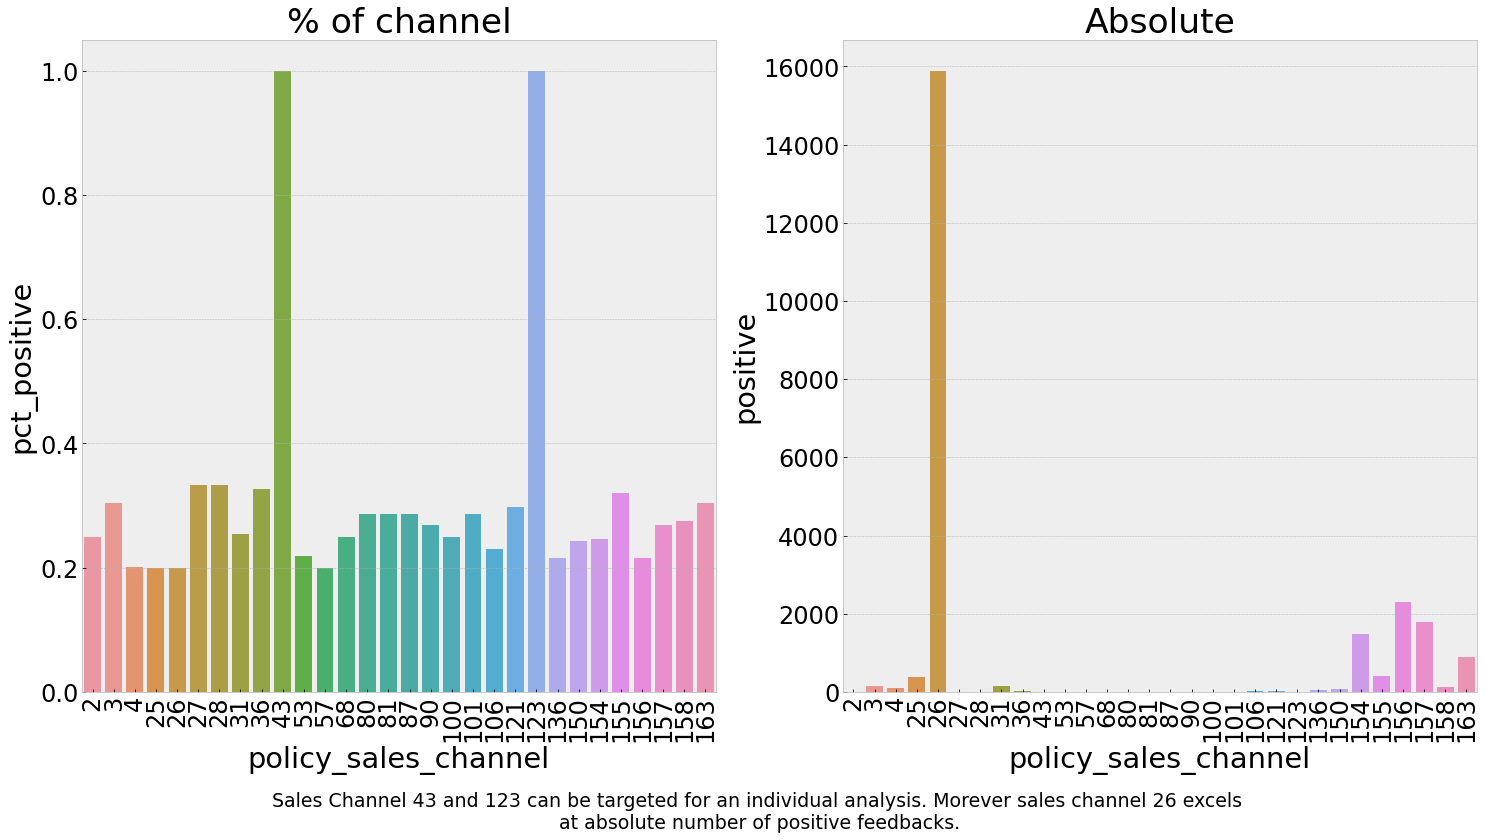

In [29]:


sales_channel.sort_values('pct_positive', ascending = False, inplace = True)
sales_channel.head(22)
plt.subplot(1,2,1)
sns.barplot(data = sales_channel.head(30), x = 'policy_sales_channel', y = 'pct_positive').set(title = '% of channel')
plt.xticks(rotation = 90);
plt.subplot(1,2,2)
sns.barplot(data = sales_channel.head(30), x = 'policy_sales_channel', y = 'positive').set(title = 'Absolute')
plt.xticks(rotation = 90);

txt=f"Sales Channel 43 and 123 can be targeted for an individual analysis. Morever sales channel 26 excels\n at absolute number of positive feedbacks."
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=19);


### Previously insured

In [30]:
df.head()
df_prev_ins = df.copy()
df_prev_ins['previously_insured'] = df_prev_ins['previously_insured'].apply(lambda x: 'Previously Insured' if x == 1 else 'Not Previous Insurance');
df_prev_ins['response'] = df_prev_ins['response'].apply(lambda x: 'Positive' if x == 1 else 'Negative');
# df_prev_ins.head()

Not Previously insured positive feedback: 46552
Not Previously insured negative feedback: 159929
Previously insured positive feedback: 158
Previously insured negative feedback: 174470


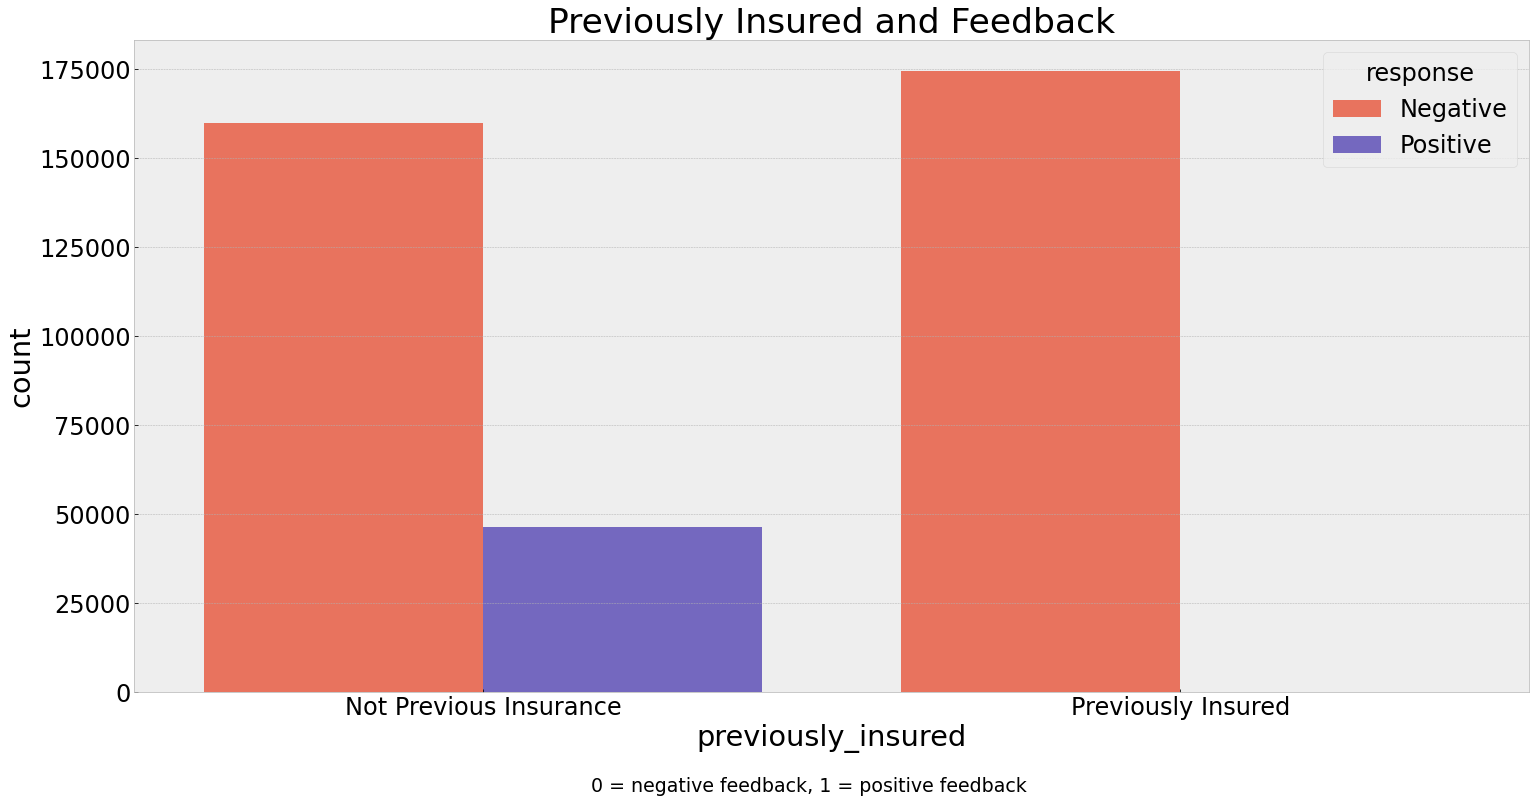

In [31]:
df_prev_ins = df.copy()
df_prev_ins['previously_insured'] = df_prev_ins['previously_insured'].apply(lambda x: 'Previously Insured' if x == 1 else 'Not Previous Insurance');
df_prev_ins['response'] = df_prev_ins['response'].apply(lambda x: 'Positive' if x == 1 else 'Negative');

sns.countplot(x = 'previously_insured', hue = 'response', data = df_prev_ins, palette=['tomato',"slateblue"] )
txt=f"0 = negative feedback, 1 = positive feedback"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=19)
plt.title("Previously Insured and Feedback")

print(f"Not Previously insured positive feedback: {df.id[(df['previously_insured'] == 0) & (df['response'] == 1)].count()}")
print(f"Not Previously insured negative feedback: {df.id[(df['previously_insured'] == 0) & (df['response'] == 0)].count()}")
print(f"Previously insured positive feedback: {df.id[(df['previously_insured'] == 1) & (df['response'] == 1)].count()}")
print(f"Previously insured negative feedback: {df.id[(df['previously_insured'] == 1) & (df['response'] == 0)].count()}")


- Previously insured plays a negative impact on answers.

### Annual Premium

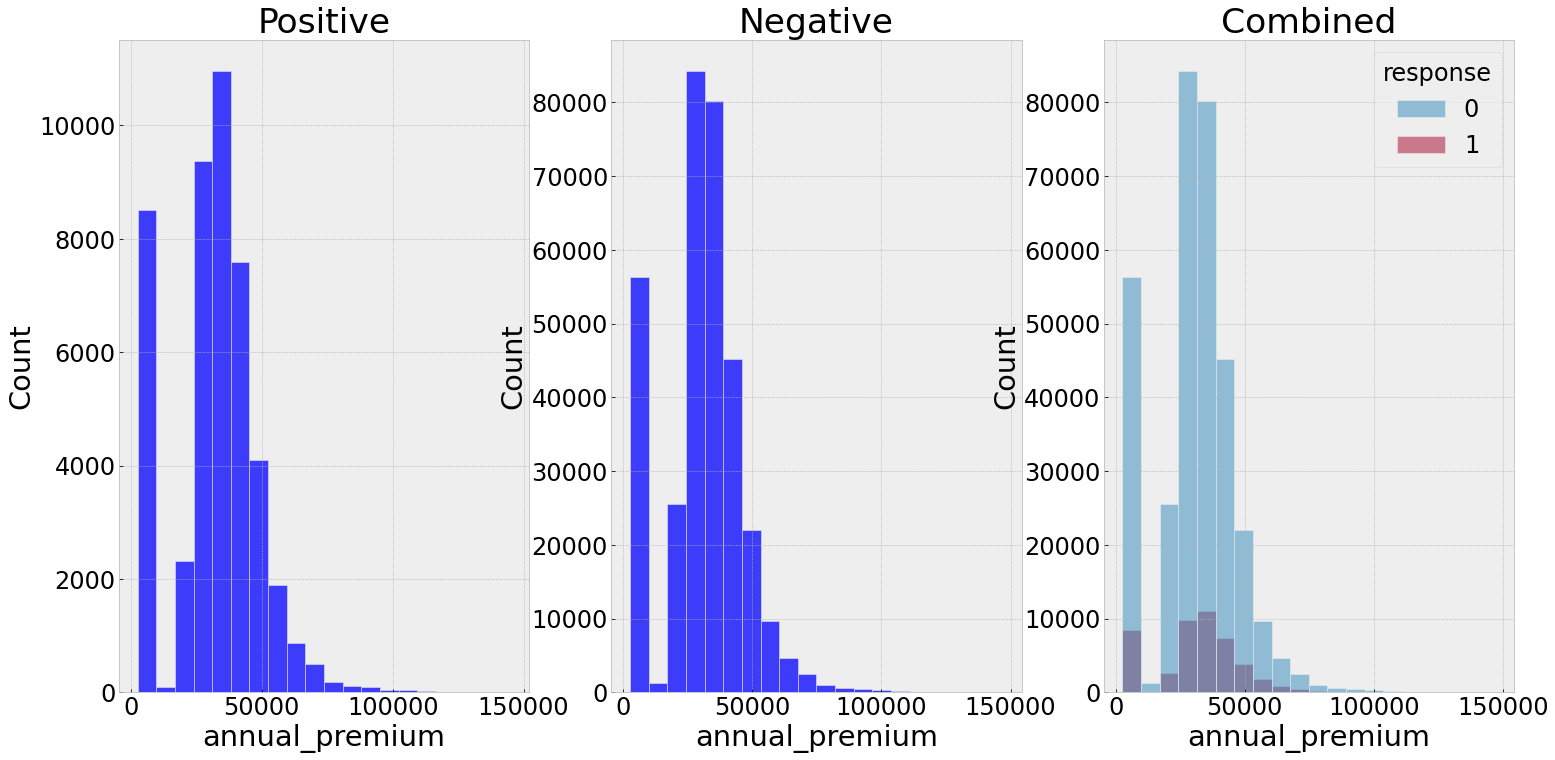

In [32]:
df_positive_feedback = df[df['response'] == 1];
df_positive_feedback = df_positive_feedback[df_positive_feedback['annual_premium'] < 150000];
df_negative_feedback = df[df['response'] == 0];
df_negative_feedback = df_negative_feedback[df_negative_feedback['annual_premium'] < 150000];
fig, axes = plt.subplots(1,3)
sns.histplot(x = 'annual_premium', data = df_positive_feedback, ax = axes[0], bins = 20).set(title = "Positive")
sns.histplot(x = 'annual_premium', data = df_negative_feedback, ax = axes[1], bins = 20).set(title = "Negative")
sns.histplot(x = 'annual_premium', data = df[df['annual_premium'] < 150000], hue = 'response', ax = axes[2], bins = 20).set(title = "Combined");

### Vintage

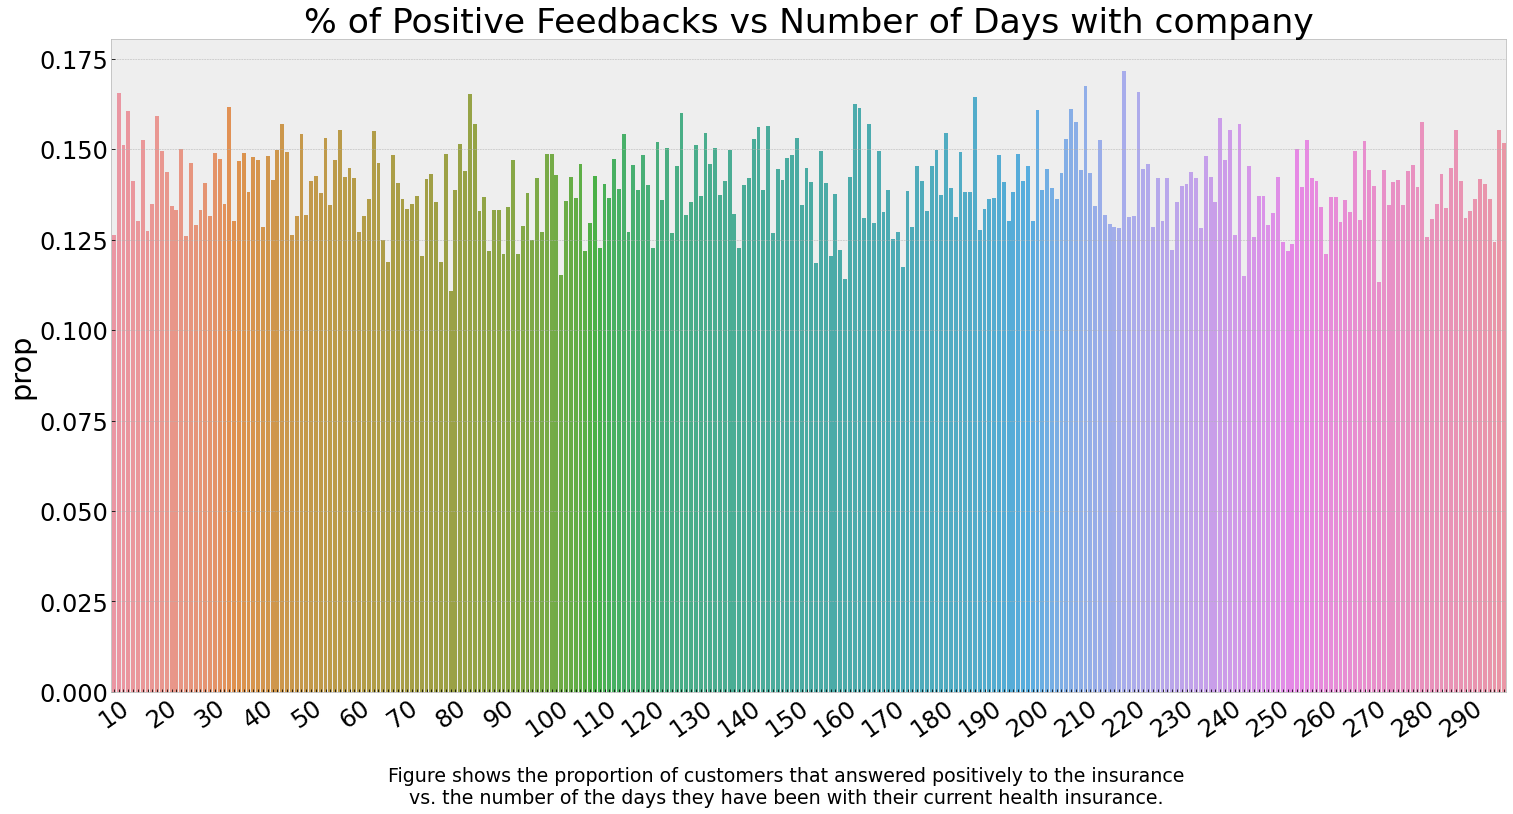

In [33]:
list_of_df_vintage_unique_values = df.vintage.unique().tolist()

total_items_vintage = []
total_items_vintage_pos = []
total_items_vintage_neg = []
for a in list_of_df_vintage_unique_values:
    total_items_vintage.append(df.id[df['vintage'] == a].count())
    total_items_vintage_pos.append(df.id[(df['vintage'] == a) & (df['response'] == 1)].count())
    total_items_vintage_neg.append(df.id[(df['vintage'] == a)  & (df['response'] == 0)].count())

vintage_df = pd.DataFrame(index = list_of_df_vintage_unique_values)
vintage_df['tot'] = total_items_vintage
vintage_df['pos'] = total_items_vintage_pos
vintage_df['neg'] = total_items_vintage_neg
vintage_df['prop'] = vintage_df['pos'] / vintage_df['neg']
#vintage_df.sort_values('prop', ascending = False)
vintage_df.sort_index(inplace = True)
bar_plot = sns.barplot(x = vintage_df.index, y = 'prop', data = vintage_df)
bar_plot.set_xticklabels(vintage_df.index, rotation = 35)
for index, label in enumerate(bar_plot.get_xticklabels()):
   if index % 10 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.title("% of Positive Feedbacks vs Number of Days with company");
plt.figtext(0.5, 0, "Figure shows the proportion of customers that answered positively to the insurance\nvs. the number of the days they have been with their current health insurance.",wrap=True, horizontalalignment='center', fontsize=19);

# plt.show()


- Difficult to see a pattern on the way the number of days customer has been with company and major incidencence of positive feedbacks.

Positive mean: 154.11224577178334
Negative mean: 154.38024336197176
# items Pos: 46710
# items Neg: 334399


Text(0.5, 1.0, 'Negative Vintage')

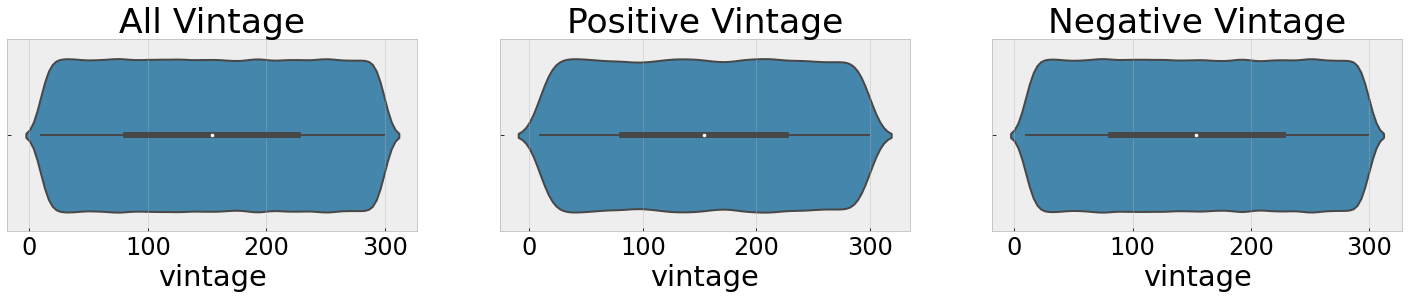

In [34]:
# sns.regplot(x = 'vintage', y = 'response', data = df)
df_positive_feedback = df[df['response'] == 1];
df_negative_feedback = df[df['response'] == 0];
print("Positive mean: {}".format(df_positive_feedback.vintage.mean()))
print("Negative mean: {}".format(df_negative_feedback.vintage.mean()))
print("# items Pos: {}".format(df_positive_feedback.shape[0]))
print("# items Neg: {}".format(df_negative_feedback.shape[0]))

plt.subplot(3,3,1)
sns.violinplot(x = 'vintage', data = df)
plt.title('All Vintage')
plt.subplot(3,3,2)
sns.violinplot(x = 'vintage', data = df_positive_feedback)
plt.title('Positive Vintage')
plt.subplot(3,3,3)
sns.violinplot(x = 'vintage', data = df_negative_feedback)
plt.title('Negative Vintage')

- Average number of the days customers has been with company is 154. That makes sense considering a product that could be valid for 1 year. Company would be constantly finishing contracts and starting new ones in this segment. 
- No clear difference on vintage box-plot between positive or negative feedback.

# Transforming Data

### Splitting Dataset

In [35]:
X = df.drop('response', axis = 1)
y = df['response'].copy()
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size = 0.2)

x_validation = x_val.copy()  # to be used in the api test
y_validation = y_val.copy()

df_clean = pd.concat([x_train, y_train], axis = 1)


In [36]:
print(x_train.shape)
print(x_val.shape)

(304887, 12)
(76222, 12)


In [37]:
df_clean.shape

(304887, 13)

- age, minmax 
- vintage, minmax
- annual_premium, standardscaler

- gender, one-hot
- region, target enc
- vehicle_age, one hot
- policy_sales_channel, frequency
- vehicle_damage, label

## Rescaling

In [38]:
# df_clean.age.hist(bins = 60)  # Rescale
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

df_clean['age'] = mms_age.fit_transform( df_clean[['age']].values)
df_clean['vintage'] = mms_vintage.fit_transform( df_clean[['vintage']].values)

pickle.dump( mms_age, open('./age_scaler.pkl', 'wb'))
pickle.dump( mms_vintage, open('./vintage_scaler.pkl', 'wb'))

## Standardization

In [39]:
ss = pp.StandardScaler()
df_clean['annual_premium'] = ss.fit_transform(df_clean[['annual_premium']].values)
pickle.dump( ss, open('./annual_premium_scaler.pkl', 'wb'))

## Normalization

In [40]:
# df_clean.response.hist()

## Encoding categorical variables

In [41]:
# df_clean.region_code.nunique()  # 53 - 
# df_clean.policy_sales_channel.nunique()  # 151 - 
# df_clean.vehicle_age.nunique()  # 3, continuous - 1,2,3... 

# Doing Gender one hot
t_enc_gender = df_clean.groupby('gender')['response'].mean()
df_clean.loc[:,'gender'] = df_clean['gender'].map( t_enc_gender)
pickle.dump(t_enc_gender, open('./target_encode_gender.pkl', 'wb'))

# Target Encoding Region
t_enc_region = df_clean.groupby('region_code')['response'].mean()
df_clean.loc[:, 'region_code'] = df_clean['region_code'].map(t_enc_region)
pickle.dump(t_enc_region, open('./target_encode_region.pkl', 'wb'))


# One Hot Encoding Vehicle
df_clean = pd.get_dummies(df_clean, prefix='vehicle_age', columns = ['vehicle_age'])
# use pandas to do transform, not saving it


# Frequency Encoding Policy Channel
# group by var and count # of examples.
fr_policy_sales_channel = df.groupby('policy_sales_channel').size() / len(df_clean)  # getting from df , not df_clean - does not cover all options for mapping
df_clean.loc[:,'policy_sales_channel'] = df_clean['policy_sales_channel'].map(fr_policy_sales_channel)
pickle.dump(fr_policy_sales_channel, open('./fe_policy_sales_channel.pkl', 'wb'))

# Vehicle Damage map label
map_key = {'Yes':1,'No':0}
df_clean.loc[:,'vehicle_damage'] = df_clean['vehicle_damage'].map(map_key)
# use pandas to do transform, not saving it

In [42]:
df_clean.head(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,binned_age,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
57941,81456,0.138057,0.184615,0.096559,0.442079,1,1,0,0.204684,0.207612,"(30, 35]",1,0,1,0
355468,176508,0.138057,0.061538,0.126273,0.442079,1,0,1,0.648042,0.328720,"(20, 25]",0,0,1,0
170593,219925,0.103473,0.015385,0.043629,0.071433,1,1,0,-1.624570,0.671280,"(20, 25]",0,0,1,0
187625,356314,0.103473,0.030769,0.103450,0.442079,1,0,1,-0.867052,0.134948,"(20, 25]",0,0,1,0
164771,172712,0.138057,0.492308,0.090885,0.242696,1,1,0,-0.388632,0.512111,"(50, 55]",0,1,0,0


## Validation Data preparation

In [43]:
# gender
x_val.loc[:,'gender'] = x_val.loc[:,'gender'].map( t_enc_gender)

# Target Encoding Region
x_val.loc[:, 'region_code'] = x_val['region_code'].map(t_enc_region)

# # One Hot Encoding Vehicle
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns = ['vehicle_age'])

# Frequency Encoding Policy Channel
# group by var and count # of examples.
x_val.loc[:,'policy_sales_channel'] = x_val['policy_sales_channel'].map(fr_policy_sales_channel)

# Vehicle Damage map label
map_key = {'Yes':1,'No':0}
x_val.loc[:,'vehicle_damage'] = x_val['vehicle_damage'].map(map_key)


x_val['annual_premium'] = ss.transform(x_val[['annual_premium']].values)
# x_val = x_val.fillna( 0 )  # some regions NOT in the test dataset ... 

x_val['age'] = mms_age.transform( x_val[['age']].values)
x_val['vintage'] = mms_vintage.transform( x_val[['vintage']].values)

In [44]:
x_val[x_val['policy_sales_channel'].isna()]  # issue with some channels not present on taining dataset
# x_val.dropna(inplace = True)
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 322737 to 67193
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     76222 non-null  int64   
 1   gender                 76222 non-null  float64 
 2   age                    76222 non-null  float64 
 3   region_code            76222 non-null  float64 
 4   policy_sales_channel   76222 non-null  float64 
 5   driving_license        76222 non-null  int64   
 6   vehicle_damage         76222 non-null  int64   
 7   previously_insured     76222 non-null  int64   
 8   annual_premium         76222 non-null  float64 
 9   vintage                76222 non-null  float64 
 10  binned_age             74929 non-null  category
 11  vehicle_age_1-2 Year   76222 non-null  uint8   
 12  vehicle_age_< 1 Year   76222 non-null  uint8   
 13  vehicle_age_> 2 Years  76222 non-null  uint8   
dtypes: category(1), float64(6), int64

# Feature Selection

## Relevance

In [45]:
x_train.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,binned_age
57941,81456,Male,32,8,152,1,< 1 Year,Yes,0,34090.0,70,"(30, 35]"
355468,176508,Male,24,29,152,1,< 1 Year,No,1,41715.0,105,"(20, 25]"
170593,219925,Female,21,25,160,1,< 1 Year,Yes,0,2630.0,204,"(20, 25]"
187625,356314,Female,22,46,152,1,< 1 Year,No,1,15658.0,49,"(20, 25]"
164771,172712,Male,52,14,124,1,1-2 Year,Yes,0,23886.0,158,"(50, 55]"


In [46]:
# model
forest = en.ExtraTreesClassifier( n_estimators = 250, random_state = 0, n_jobs = -1)

# data prep
x_train_n = df_clean.drop(['id','response','binned_age'], axis = 1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)




ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                 feature  importance
0                vintage    0.272701
0         annual_premium    0.244994
0                    age    0.167786
0            region_code    0.103822
0         vehicle_damage    0.069444
0   policy_sales_channel    0.059458
0     previously_insured    0.054551
0   vehicle_age_< 1 Year    0.012530
0   vehicle_age_1-2 Year    0.006960
0                 gender    0.004626
0  vehicle_age_> 2 Years    0.002662
0        driving_license    0.000465


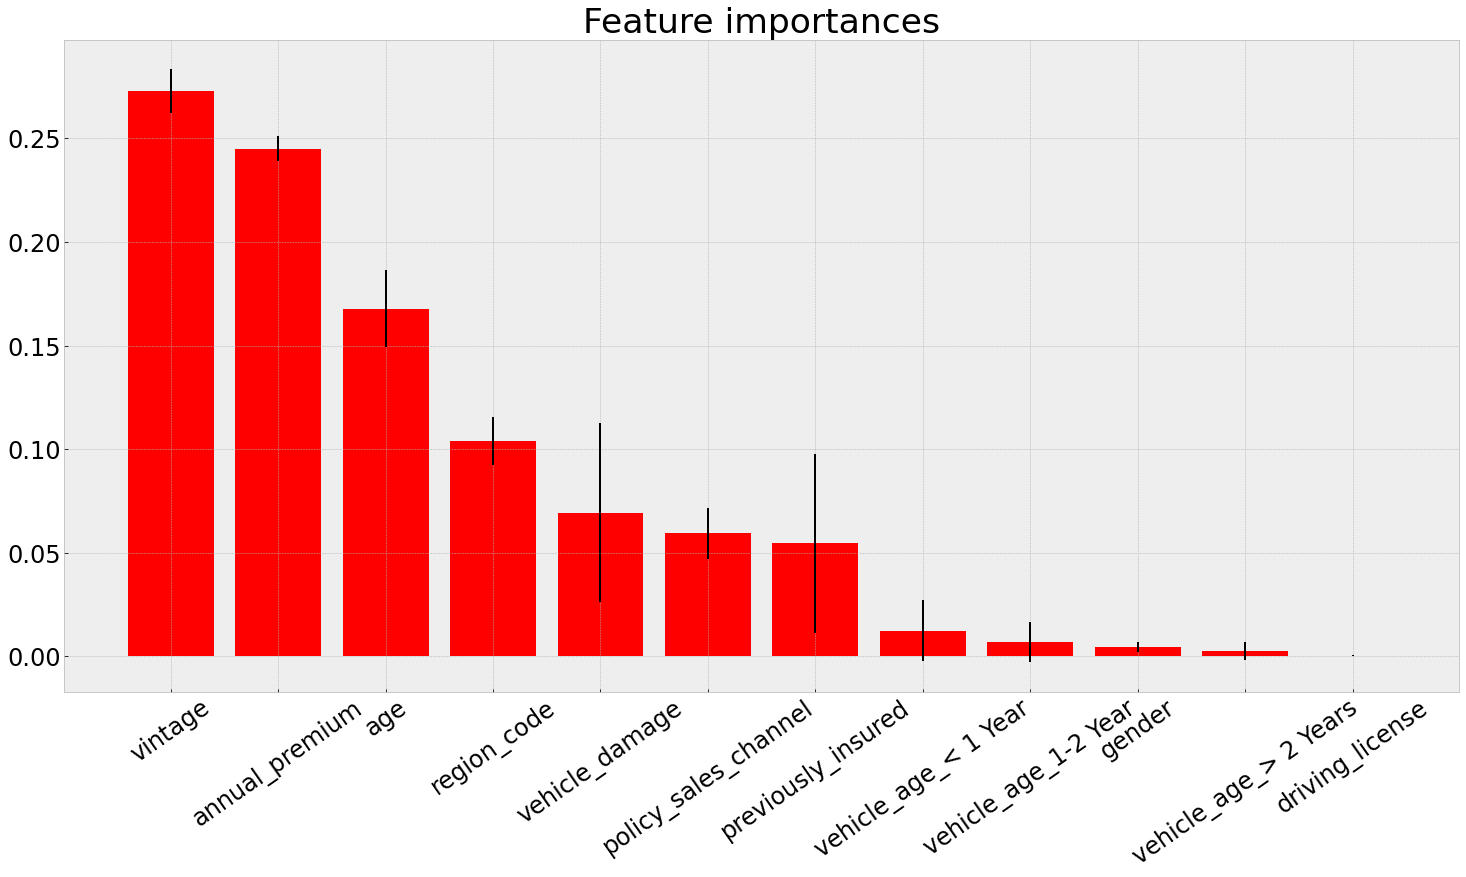

In [47]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df_imp = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance':j}, index = [0])
    df_imp = pd.concat([df_imp,aux], axis = 0)

df_imp = df_imp.sort_values('importance', ascending = False)
print(df_imp.sort_values('importance', ascending = False))
df_imp = df_imp.sort_values('importance', ascending = False)
# graph plot
plt.figure()
plt.title("Feature importances")
# plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr=std[indices], align='center')
plt.bar(df_imp.feature, df_imp.importance, color = 'r', yerr=std[indices], align='center')
#plt.bar(df_imp.feature, df_imp.importance)
#plt.xticks(range(x_train_n.shape[1]), indices)
plt.xticks(df_imp.feature, rotation = 35)
#plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [48]:
# forest.feature_importances_

# Machine Learning

In [49]:
# df_imp.feature.values

In [50]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'previously_insured','policy_sales_channel']

x_train = df_clean[cols_selected]
x_val_full = x_val.copy()  # so we can work with all columns in performance section
x_val = x_val[cols_selected]

In [51]:
x_train.shape

(304887, 7)

## K Neighbors

In [52]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors =  2)

# training
knn_model.fit(x_train, y_train)

# model prediction - generalization
yhat_knn = knn_model.predict_proba( x_val )


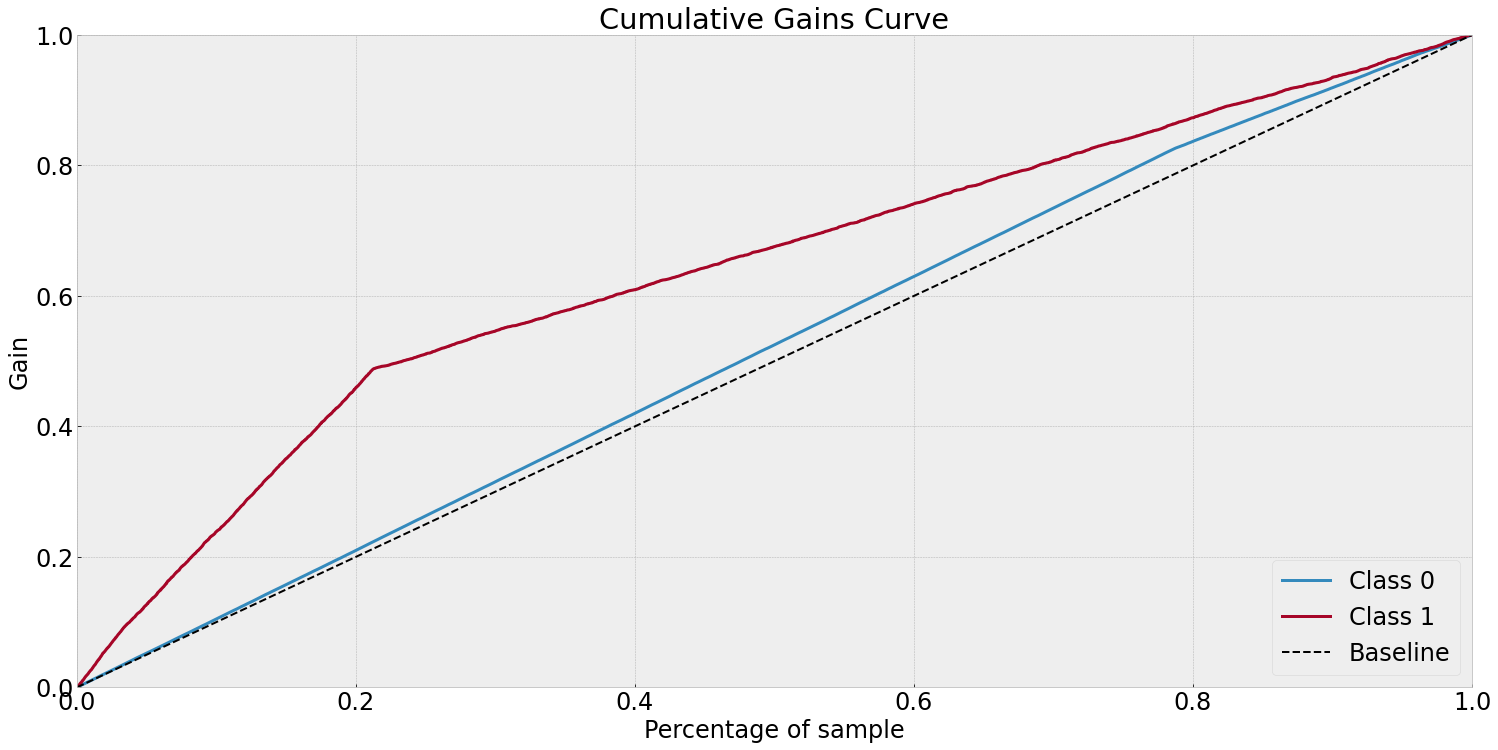

In [53]:
# cumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

- This model sorts the first ~ 21% with greater efficiency.

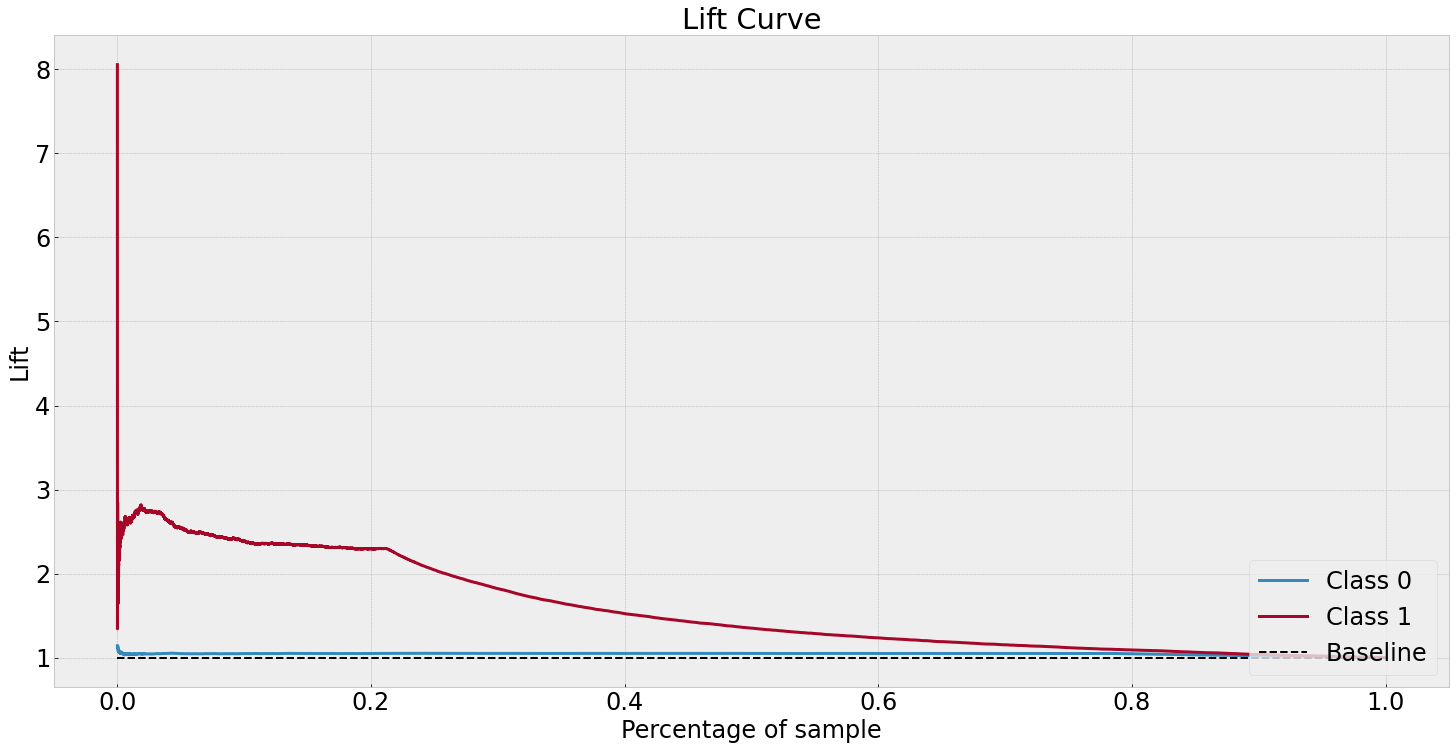

In [54]:
# Lift curve KNN
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

- Lift curve show us how many times the list ordenation would be better for reaching customers most likely to adhere to the new product, eg. if contacting only 20% of curtomers, list would be better ~ 2.3 times.

## Logistic Regression

(76222, 7)

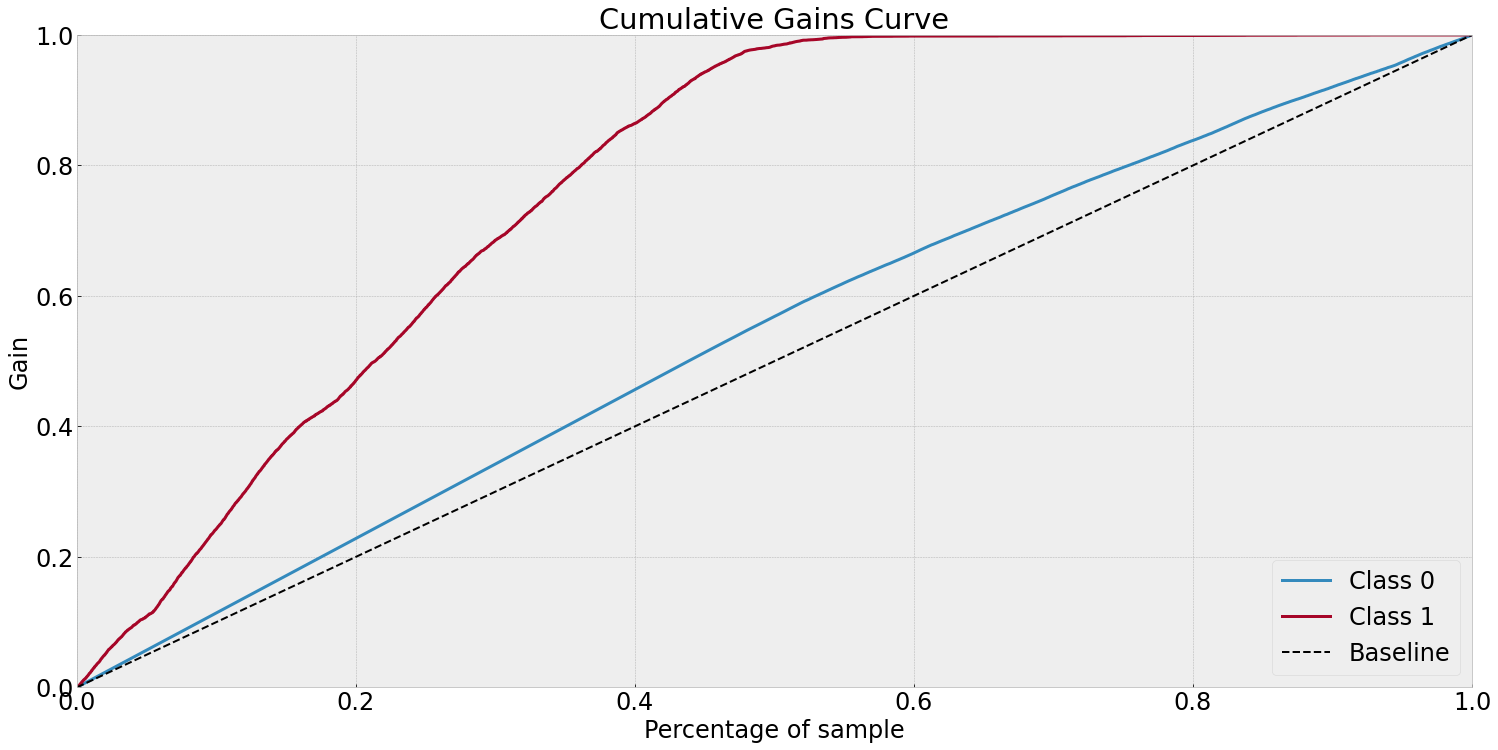

In [55]:
# model obj
lr_model = lm.LogisticRegression( random_state = 42)

# training
lr_model.fit( x_train, y_train)

# predict
yhat_lr = lr_model.predict_proba( x_val)

# gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr)

x_val.shape

- Highly efficient in consistently sorting the interested customers for the new product. Observe how it is possible to reach almost all customers by contacting roughly 50% of the clients.

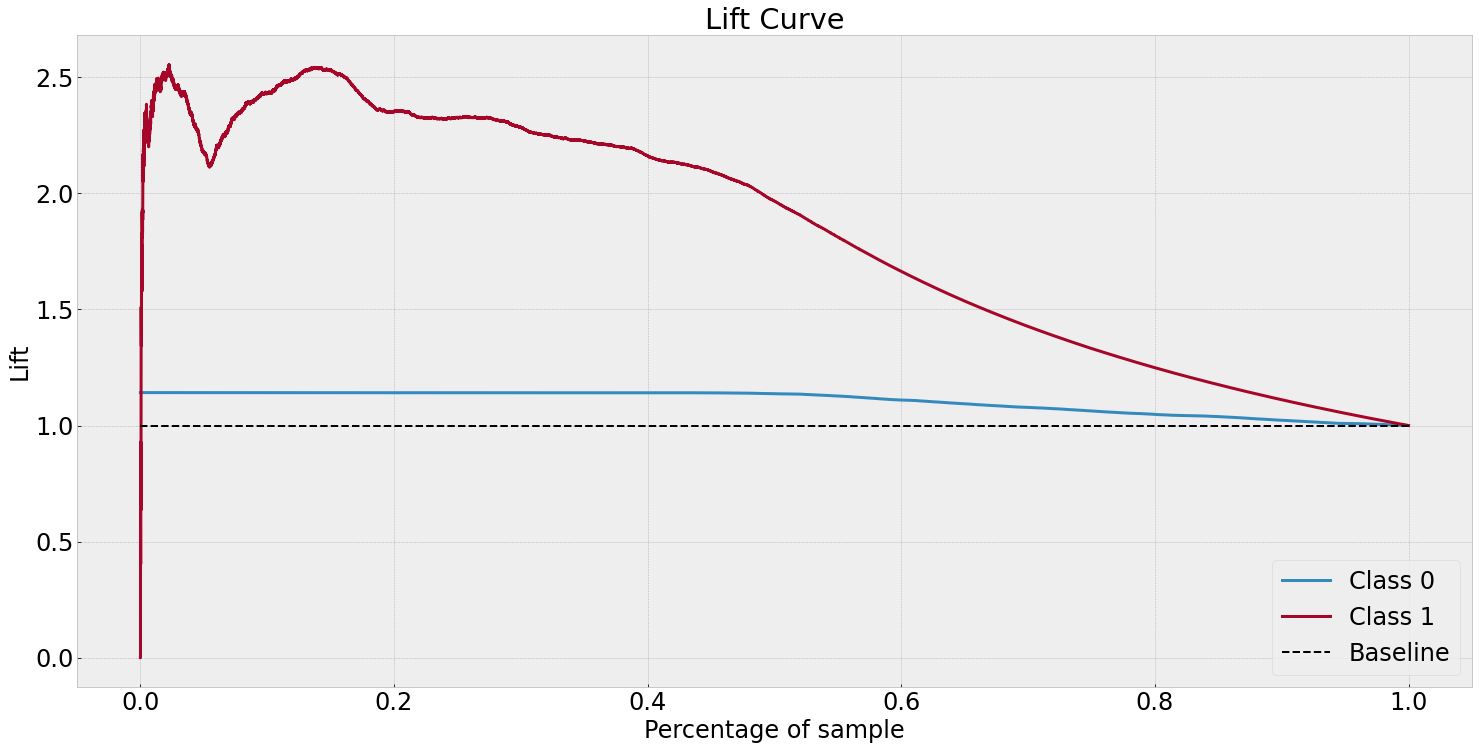

In [56]:
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

- If reaching only 40% of the customers through the list, the ordenated list is around 2.3 times better than random contacting.

# Model Performance - Recall at K

In [57]:
def precision_at_k( data, k = 2000):
    
    # reset index and keep ids
    data = data.reset_index(drop = True)

    # do ranking order
    data['ranking'] = data.index + 1

    # precision at k:
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k = 2000):
    data = data.reset_index(drop = True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

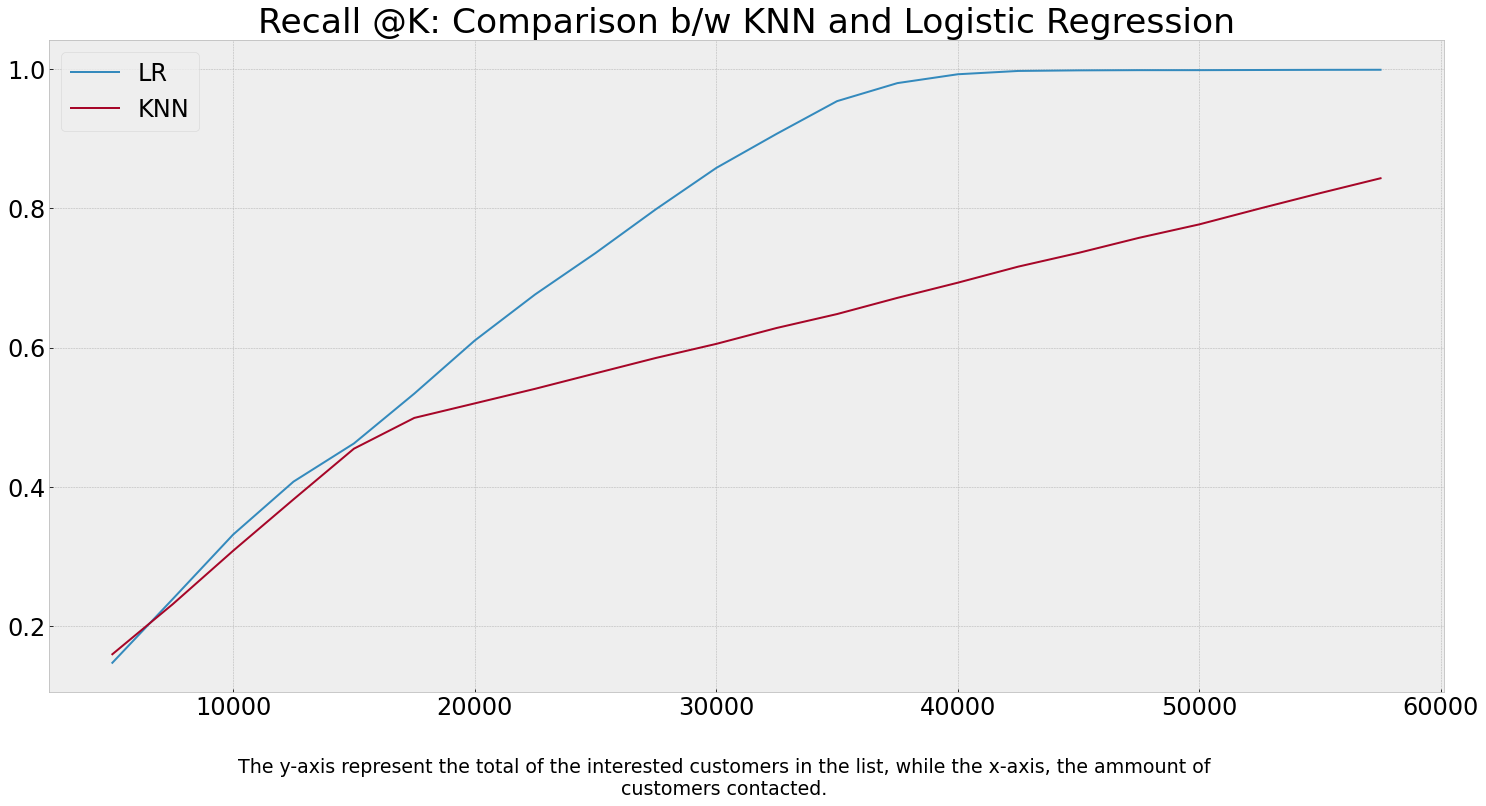

In [78]:

####
# print("LR:")
model_perf_lr = x_val_full.copy()
model_perf_lr['response'] = y_val.copy()

# score propensity
# model_perf['score'] = yhat_knn[:,1].tolist()
model_perf_lr['score'] = yhat_lr[:,1].tolist()

# sort customers according to prop. score
model_perf_lr = model_perf_lr.sort_values('score', ascending = False)

# set id column from index
model_perf_lr['id'] = model_perf_lr.index  # set id column from index.

# computing precision 
# print(f'Total data in evaluation sample: {x_val.shape[0]}')
# precision_at_ = precision_at_k(model_perf_lr, k=9000)
# print('Precision at K50: {}'.format(precision_at_))

# recall_at_ = recall_at_k(model_perf_lr, k=9000)
# print('Recall at K50: {}'.format(recall_at_))

####
# print('KNN:')
model_perf_knn = x_val_full.copy()
model_perf_knn['response'] = y_val.copy()

# score propensity
# model_perf['score'] = yhat_knn[:,1].tolist()
model_perf_knn['score'] = yhat_knn[:,1].tolist()

# sort customers according to prop. score
model_perf_knn = model_perf_knn.sort_values('score', ascending = False)

# set id column from index
model_perf_knn['id'] = model_perf_lr.index  # set id column from index.

# computing precision 
# print(f'Total data in evaluation sample: {x_val.shape[0]}')
# precision_at_ = precision_at_k(model_perf_knn, k=9000)
# print('Precision at K: {}'.format(precision_at_))

# recall_at_ = recall_at_k(model_perf_knn, k=9000)
# print('Recall at K: {}'.format( recall_at_))


recall_list_knn = []
recall_list_lr = []
k_list = np.arange(5000, 60000, 2500)
for a in k_list:
    recall_list_knn.append(recall_at_k(model_perf_knn, a))
    recall_list_lr.append(recall_at_k(model_perf_lr, a))
#     print('Doing k = {}'.format(a))

plt.title("Recall @K: Comparison b/w KNN and Logistic Regression")
plt.plot(k_list,recall_list_lr , label = 'LR');
plt.plot(k_list,recall_list_knn , label = 'KNN');
plt.figtext(0.5, 0.01, 'The y-axis represent the total of the interested customers in the list, while the x-axis, the ammount of\ncustomers contacted.', wrap=True, horizontalalignment='center', fontsize=19);
plt.legend(loc='best')
plt.show();

- Logistic Regression has a steeper gain. Translates in a better classification. On the graph it is possible to see that contacting 20.000 customers on KNN would hit around 50% of interested, while on Logistic Regression, roughly 60%.

# Business insights

## The ammount of relevant customers hit when contacting 20.000 customers

In [59]:
k = 20000
recall_at_ = recall_at_k(model_perf_lr, k=k)
print('Recall at K: {}'.format( recall_at_))
print(f'Total number of customers currently being tested: {x_val.shape[0]}')
print(f'20.000 people represents {(100 * k / x_val.shape[0]):.2f}% of testing db.')

Recall at K: 0.6102948948314132
Total number of customers currently being tested: 76222
20.000 people represents 26.24% of testing db.


Sales team will be able to hit 52% of interested people by doing 20.000 calls.

## Reaching out to 40.000 people what percentage will of interested people can be contacted?

In [60]:
k = 40000
recall_at_ = recall_at_k(model_perf_lr, k=k)
print('Recall at K: {}'.format( recall_at_))
print(f'40.000 people represents {(100 * k / x_val.shape[0]):.2f}% of testing db.')

Recall at K: 0.9924955078744319
40.000 people represents 52.48% of testing db.


Sales team can reach 99% of interested people by calling 40.000 people which represents 52% of the database.

## In order to reach 80% of interested customers on the chosen model how many people need to be contacted?

In [73]:
y_val.head()

322737    0
256372    0
269074    0
375340    0
58288     0
Name: response, dtype: int64

In [74]:
df_ = x_val.copy()
df_.head()
df_['score'] = yhat_lr[:,1].tolist()
df_['response'] = y_val
df_ = df_.sort_values('score', ascending = False)
df_.head()
df_ = df_.reset_index(drop = True)
df.head()
df_['ranking'] = df_.index+1
df_.head()
df_['precision_at_k'] = df_['response'].cumsum()/df_['ranking']
df_['recall_at_k'] = df_['response'].cumsum()/df_['response'].sum()

cx_to_80 = df_[df_['recall_at_k'] >= 0.8].index.min()

print(f"Total customers to be contacted to achieve 80% of interested: {cx_to_80}")
print(f"That represents {100* cx_to_80 / df_.shape[0]:.2f}% of the database.")
print(f"\n -> Team needs to reach {cx_to_80} customers in order to hit 80% of the customers that are likely to answer yes to the new pruduct.")

Total customers to be contacted to achieve 80% of interested: 27546
That represents 36.14% of the database.

 -> Team needs to reach 27546 customers in order to hit 80% of the customers that are likely to answer yes to the new pruduct.


# Deploy

In [75]:
# Saving trained model:
# Logistic Regression:
pickle.dump( lr_model, open('./model_log_regression.pkl', 'wb'))

## Health Insurance Class

    ### Health Insurance Class

class HealthInsurance:
    def __init__(self):
        self.home_path = './'
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'annual_premium_scaler.pkl'))
        self.age_scaler = pickle.load(open(self.home_path + 'age_scaler.pkl'))
        self.vintage_scaler = pickle.load(open(self.home_path + 'vintage_scaler.pkl'))
        self.target_encode_gender_scaler =  pickle.load(open(self.home_path + 'target_encode_gender.pkl'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'target_encode_region.pkl'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + 'fe_policy_sales_channel.pkl'))
        
    def data_cleaning( self, df1):
        # Column rename
        # columns_names = [ ... ]
        # 
        # 5.48m
        # df1.columns = cols_names
        
        return df1
    
    def feature_engineering(self, df2):
        # Vehicle Damage map label
        map_key = {'Yes':1,'No':0}
        df_clean.loc[:,'vehicle_damage'] = df_clean['vehicle_damage'].map(map_key)
        
        # One Hot Encoding Vehicle
        df_clean = pd.get_dummies(df_clean, prefix='vehicle_age', columns = ['vehicle_age'])
        
        return df2
    
    def data_preparation(self, df_clean):
        # Standardization
        
        df_clean['annual_premium'] = self.annual_premium_scaler.transform(df_clean[['annual_premium']].values)

        # rescaling
        df_clean['age'] = self.age_scaler.transform( df_clean[['age']].values)
        df_clean['vintage'] = self.vintage_scaler.transform( df_clean[['vintage']].values)
        
        # Doing Gender one hot
        df_clean.loc[:,'gender'] = df_clean['gender'].map( self.target_encode_gender_scaler)

        # Target Encoding Region
        df_clean.loc[:, 'region_code'] = df_clean['region_code'].map(self.target_encode_region_code_scaler)
        pickle.dump(t_enc_region, open('./target_encode_region.pkl', 'wb'))


        # One Hot Encoding Vehicle
        df_clean = pd.get_dummies(df_clean, prefix='vehicle_age', columns = ['vehicle_age'])
        # use pandas to do transform, not saving it


        # Frequency Encoding Policy Channel
        # group by var and count # of examples.
        
        df_clean.loc[:,'policy_sales_channel'] = df_clean['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        

        # Vehicle Damage map label
     #         map_key = {'Yes':1,'No':0}
    #         df_clean.loc[:,'vehicle_damage'] = df_clean['vehicle_damage'].map(map_key)
        # use pandas to do transform, not saving it
        
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                         'vehicle_damage', 'previously_insured','policy_sales_channel']
        
        return df_clean[ cols_selected ]

    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient = 'records', date_format = 'iso')
        
        
        

## API Handler

import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

     # loads model
path = './'
model = pickle.load(open(path + 'model_health_insurance.pkl', 'rb'))  # memory bank alt.
   
     # API init
app = Flask( __name__ )

@app.route ('/predict', methods = ['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance( test_json, dict):  # unique item
            test_raw = pd.DataFrame( test_json, index = [0])
        else:  # multiple items
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
        
        # start Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df = pipeline.data_cleaning( test_raw )
        
        # features
        df = pipeline.feature_engineering( df )
        
        # data prep
        df = pipeline.data_preparation ( df )
        
        # prediction
        df = pipeline.get_prediction(model, test_raw, df)
        
        return df
    else:
        return Response('{}', status = 200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug = True)
    
    
    
        
        

## API test

In [ ]:
import requests
import json
# load dataset
df_test = x_validation #.drop('response', axis = 1)
df_test['response'] = y_validation


cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'previously_insured','policy_sales_channel']

cols_selected.append('vehicle_age')
cols_selected.append('gender')
df_test = df_test[cols_selected]

# df_test = df_test.sample(10)

#converting df to json

data = json.dumps( df_test.to_dict(orient = 'records'))
# df_test.head()

In [ ]:
# print(df_test.head())
#df_test = df_test[cols_selected]
#data = json.dumps( df_test.to_dict(orient = 'records'))
# df_test = pd.get_dummies(df_test, prefix='vehicle_age', columns=['vehicle_age'])
# df_test.head()

In [ ]:
 #API call
# url = 'http://0.0.0.0:5000/predict'
# url = 'https://cross-sell-insurance-api.herokuapp.com:5000/predict'
url = 'https://cross-sell-insurance-api.herokuapp.com/predict'
# url = 'http://localhost:5000/predict'
header = {'Content-type': 'application/json'}

# print(f'Sending {df_test.head()}')
r = requests.post( url, data=data, headers=header)
print('Status code {}'.format(r.status_code))


In [ ]:
# data

In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys() )
d1.sort_values('prediction', ascending = False).head()

In [ ]:
d1.sample(14)

## Write x_val to csv so we can implement Google Sheets API

In [ ]:
x_val.to_csv('x_val.csv')
y_val.to_csv('y_val.csv')
df_test.to_csv('df_test.csv')